# Using TIMESAT to prepare crop yield estimation metrics
By Stefano and Sitian

This document explains Stefano and Sitian's process on extracting crop phenological information for agroimpacts projects.

Researchers have found that the phenological information (the growth and death cycle of vegetation) can be used to estimate crop yield.  Time-series NDVI is a good proxy of large scale crop phenology.  While the satellite observed time-series NDVI is limited on its quantity by cloud cover and quality by aerosals etc.  Therefore, some of the NDVI values were missing, and some others were jumping up and down in a monthly period, which is believed not real.  Here  is an example: 

<img src="img/raw_NDVI_r835_c3820.png" width="800">
(figure: Time-series NDVI from 2001-2017, somewhere in the north-east of Zambia, MOD13Q1 Vegetation Product)

A popular solution is to preprocess the raw time-series NDVI into a sine wave-like curve for each growing season, which is continuous and only up and down once in a growing cycle. 
We decided to use TIMESAT to do this job.  

## A short introduction to timesat

TIMESAT is a free software desinged by Lars Eklundha and Per Jönssonb.  It provides user-friendly tools for prepraing phenology information, primarily 1) time-series NDVI reconstruction; 2) phenological parameter extraction (e.g., starting and ending points of season, integral of seasonal NDVI).

![title](img/TIMESAT_Main.png)
(figure: The main window of TIMESAT)

The major module we used in this task including:
TSM_GUI      - an interactive window dispay for trying different filters and season extraction parameters.
TSM_settings - similar to TSM_GUI, but is an setting file editor. The output setting file will be the input for TSF_process
TSF_process  - process the time-series images based on the configurations in the setting file.  Can do multi-processing.
               May take 6 - 10 hours to process our dataset.
TSF_seas2img - export the extracted phenological information as image. e.g., the small integral of the second growing season.

![title](img/TSF_GUI.png)

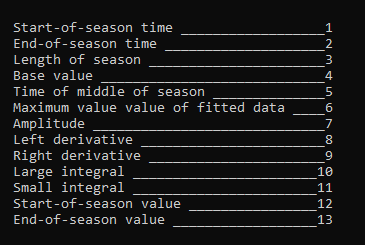


1. Goal
Use TIMESAT, given the raw time-series NDVI as input, extract the integral of the NDVI curve for each growing season.  Some intermediate output may also be useful, such as the reconstructed time-series NDVI, starting and ending time andvalues of each growing season.


2. Method, inputs and settings
We use savitzky-golay filter to reconstruct time-series NDVI.
window size: 4
valid data range: 0-10000
Other parameter keeps default.

We define the start and ending season as:
start and end of season method: seasonal amplitude
start: 20%
end: 20%




3.Result
![title](img/Small_Integ.png)


3. Problems encountered:
1)The TSM_GUI tool is mysterious, it does not provide consistent result with TSF_Process.  The TSM_GUI drops several points in the interactive display when user use default "none" method for spkie removal.  
2)The starting and ending time is mysterious.  We found it is about 1 to 2 time step ahead of the real starting and ending time.
  The starting and ending values are correct.
  
3) Suspicous wrong statement in the user guide "TIMESAT 3.3 with seasonal trend decomposition and parallel processing Software Manual" page 24.  The manual states that the seasonal amplitude method defines as:
"(1) The ﬁrst method is based on the seasonal amplitude, deﬁned between the base level and the maximum value for each individual season. The start occurs when the left part of the ﬁtted curve has reached a speciﬁed fraction of the amplitude, counted from the base level. The end of season is deﬁned similarly, but for the right side of the curve."
While Sitian use TSM_GUI found it actually takes fraction between left and right minimum and maximum value of a curve, rather than base (average of min and max) value. 

http://web.nateko.lu.se/timesat/docs/TIMESAT33_SoftwareManual.pdf

In [1]:
import gdal
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import os

1. set harmonic interpolation time-series DIR

In [2]:
#DIR = r'D:\GEE_LOCAL_MACHINE\2000-2017_Qa_0n1-harmo-\\'
#ns = [fn for fn in os.listdir(DIR) if fn[-3:]=='rst']


2. set fitted (Timesat fitted) time-series

In [3]:
DIR_RAW = r'F:\Agrimpacts\GEE_timesat\test-3-Qa0n1_raw\test-3-raw\\'
fns_raw = [fn for fn in os.listdir(DIR_RAW)]

DIR_FITTED = r'F:\Agrimpacts\GEE_timesat\test-3-Qa0n1_raw\test-3fitted\\'
#'F:\Agrimpacts\GEE_timesat\test-2\fitted\\'
fns_fitted = [fn for fn in os.listdir(DIR_FITTED)]

3. set window and pixel of interest

In [18]:
date_window = (1,391)
pix_of_interest = (3820,835) #col,row

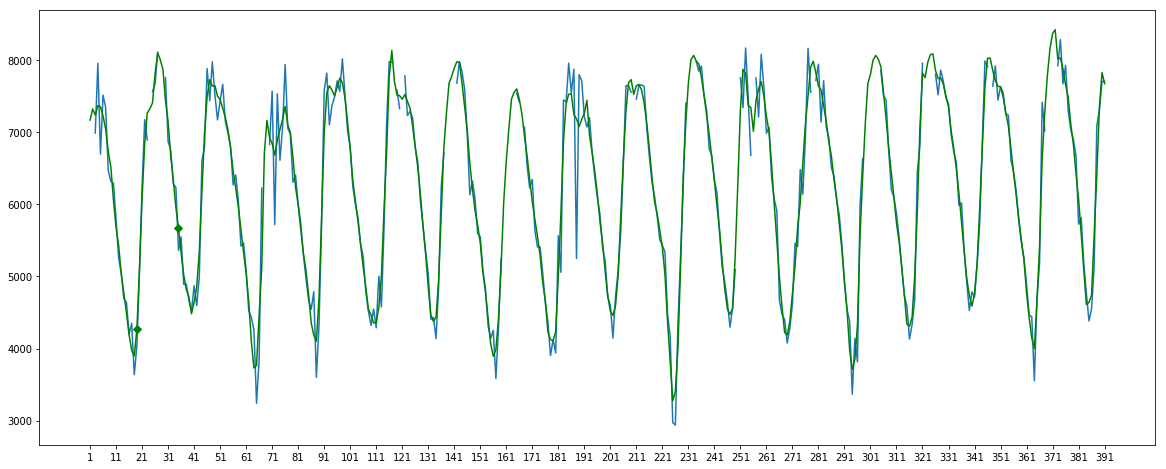

In [42]:
NDVI_ts = []
NDVI_fitted = []

# for rst
# for i in range(date_window[0]-1,date_window[1]):

#     ds = gdal.Open(DIR+fns[i])
#     band = ds.GetRasterBand(1)
#     pix_val = int(band.ReadAsArray(pix_of_interest[0],pix_of_interest[1],1,1))
#     NDVI_ts.append(pix_val)

for i in range(date_window[0]-1,date_window[1]):

    array = np.fromfile(DIR_RAW+fns_raw[i], dtype='int16', sep="")
    array =array.reshape(4371,5226)
    #plt.figure()
    #skio.imshow(array, alpha=.3)
    pix_val = int(array[pix_of_interest[1]][pix_of_interest[0]])
    if pix_val >10000:
        pix_val = np.NaN
    NDVI_ts.append(pix_val) 


for i in range(date_window[0]-1,date_window[1]):

    array = np.fromfile(DIR_FITTED+fns_fitted[i], dtype='int16', sep="")
    array =array.reshape(4371,5226)
    #plt.figure()
    #skio.imshow(array, alpha=.3)
    pix_val = int(array[pix_of_interest[1]][pix_of_interest[0]])
    if pix_val >10000:
        pix_val = np.NaN
    NDVI_fitted.append(pix_val) 
 
#
#season_start_array = np.fromfile(r'F:\Agrimpacts\GEE_timesat\test_season-2_season1', dtype='float16', sep="")
season_start_array = np.fromfile(r'F:\Agrimpacts\GEE_timesat\test-3-Qa0n1_raw\test-3-start_season1', dtype='int16', sep="")
season_start_array = season_start_array.reshape(4371,5226)
season_start = int(season_start_array[pix_of_interest[1]][pix_of_interest[0]])

season_end_array = np.fromfile(r'F:\Agrimpacts\GEE_timesat\test-3-Qa0n1_raw\test-3-end_season1', dtype='int16', sep="")
season_end_array = season_end_array.reshape(4371,5226)
season_end = int(season_end_array[pix_of_interest[1]][pix_of_interest[0]])

season_base_array = np.fromfile(r'F:\Agrimpacts\GEE_timesat\base_season1', dtype='float32', sep="")
season_base_array = season_base_array.reshape(4371,5226)
season_base = int(season_base_array[pix_of_interest[1]][pix_of_interest[0]])

season_max_array = np.fromfile(r'F:\Agrimpacts\GEE_timesat\test-3-Qa0n1_raw\max_val_season1', dtype='int16', sep="")
season_max_array = season_max_array.reshape(4371,5226)
season_max = int(season_max_array[pix_of_interest[1]][pix_of_interest[0]])


x = []
for i in range(1,len(NDVI_fitted)+1):
    x.append(i)

plt.figure(figsize=(20,8))   
markers_on=[season_start-2, season_end-2]
plt.plot(x,NDVI_ts)    
plt.plot(x,NDVI_fitted, '-gD',markevery=markers_on)
#plt.plot([30,50],[season_base,season_base])
#plt.plot(season_max)
plt.xticks(np.arange(min(x), max(x)+1, 10))
plt.show()

In [20]:
markers_on

[20, 36]

In [23]:
for i in enumerate(NDVI_ts[0:47]):
    print(i)

(0, 7137)
(1, nan)
(2, 6989)
(3, 7957)
(4, 6698)
(5, 7515)
(6, 7343)
(7, 6466)
(8, 6319)
(9, 6294)
(10, 5787)
(11, 5253)
(12, 5040)
(13, 4689)
(14, 4640)
(15, 4199)
(16, 4351)
(17, 3637)
(18, 4039)
(19, 5072)
(20, 6249)
(21, 7175)
(22, 6894)
(23, nan)
(24, 7564)
(25, 7671)
(26, 8110)
(27, nan)
(28, nan)
(29, 7758)
(30, 6872)
(31, 6756)
(32, 6285)
(33, 6233)
(34, 5361)
(35, 5548)
(36, 4891)
(37, 4893)
(38, 4669)
(39, 4524)
(40, 4871)
(41, 4596)
(42, 4995)
(43, 6607)
(44, 6796)
(45, 7883)
(46, 7439)


In [27]:
season_max 

8100

In [28]:
season_start_val_array = np.fromfile(r'F:\Agrimpacts\GEE_timesat\test-3-Qa0n1_raw\start_val_season1', dtype='int16', sep="")
season_start_val_array = season_start_val_array.reshape(4371,5226)
season_start_val = int(season_start_val_array[pix_of_interest[1]][pix_of_interest[0]])
season_start_val

4738

In [29]:
for i in enumerate(NDVI_fitted[0:47]):
    print(i)

(0, 7169)
(1, 7324)
(2, 7239)
(3, 7369)
(4, 7355)
(5, 7225)
(6, 7044)
(7, 6732)
(8, 6520)
(9, 6057)
(10, 5682)
(11, 5422)
(12, 5038)
(13, 4768)
(14, 4494)
(15, 4192)
(16, 3974)
(17, 3897)
(18, 4266)
(19, 5104)
(20, 6078)
(21, 6839)
(22, 7267)
(23, 7326)
(24, 7406)
(25, 7814)
(26, 8100)
(27, 8005)
(28, 7876)
(29, 7437)
(30, 7151)
(31, 6679)
(32, 6337)
(33, 5955)
(34, 5667)
(35, 5330)
(36, 5021)
(37, 4821)
(38, 4715)
(39, 4482)
(40, 4642)
(41, 4849)
(42, 5351)
(43, 6182)
(44, 6984)
(45, 7492)
(46, 7730)


In [30]:
season_end_val_array = np.fromfile(r'F:\Agrimpacts\GEE_timesat\test-3-Qa0n1_raw\end_val_season1', dtype='int16', sep="")
season_end_val_array = season_end_val_array.reshape(4371,5226)
season_end_val = int(season_end_val_array[pix_of_interest[1]][pix_of_interest[0]])
season_end_val

5205

In [32]:
season_small_integ_array = np.fromfile(r'F:\Agrimpacts\GEE_timesat\test-3-Qa0n1_raw\small_integ_season1', dtype='float32', sep="")
season_small_integ_array = season_small_integ_array.reshape(4371,5226)
season_small_integ = int(season_small_integ_array[pix_of_interest[1]][pix_of_interest[0]])
season_small_integ

46058

In [52]:
#double check the small integral, a rough estimation (large integral - base_val*season_length)
from numpy import trapz
NDVI_fitted[18:36]
x = range(1,len(NDVI_fitted[18:36])+1)
area = trapz(NDVI_fitted[18:36],x)-4200*16
area

48639.0

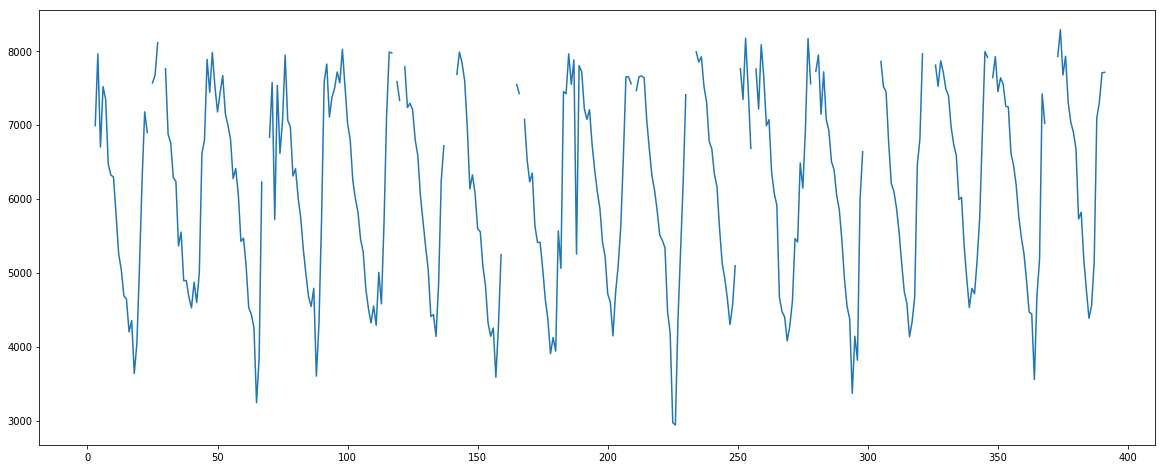

In [54]:
x = []
for i in range(1,len(NDVI_fitted)+1):
    x.append(i)
plt.figure(figsize=(20,8))   
plt.plot(x,NDVI_ts)    
plt.show()